In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## What is backpropagation?

Micrograd is an autograd engine which implements backpropagation. 

* Backpropagation is an algorithm which allows one to efficiently evaluate the gradient of a **loss function** with respect to the weights of a neural network
* This lets us iteratively tune the weights to minimise the loss function, and hence improve the performance of the NN

## What is a derivative?
What information does it contain?

### 1. Define (and call) a single-value scalar function `f(x)`

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

# call function
f(3.0)

20.0

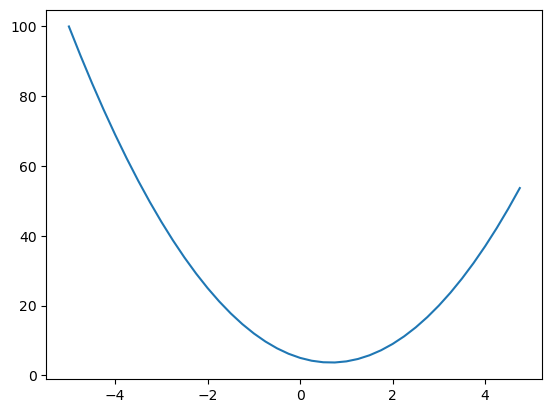

In [3]:
# plot function to understand its shape
xs = np.arange(-5, 5, 0.25) # array of x values
ys = f(xs)                  # corresp. array of y values
plt.plot(xs, ys)

### 2. Take the derivative (i.e. `df(x)/dx` at any input point `x`)

* Recall, in Calculus class, you'd use the various **analytical** rules (e.g. product rule etc) on the function $3x^2 -4x + 5$ defined above to find the **analytical** expression for the derivative of $f(x)$.
* In NNs, no one does this. The expression would have tens of thousands of terms.

#### Instead, by definition a derivative is:
$$L = \lim_{h \to 0} \frac{f(x+h)-f(x)}{h}$$

Which tells us the sensitivity (aka slope of the response) of the function, to when you nudge $x$ by an infinitesimal amount $h$

In [4]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x))/h # recall: rise/run; that's why we "normalise" by dividing by h

14.00000009255109

Note, we can confirm analytically for this function; $\frac{d}{dx}(3x^2-4x+5) = 6x-4 \implies 6(3)-4=14$

### 3. Derivative of `d` wrt multiple inputs `a`, `b`, and `c`

In [5]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0   
d = a*b + c
print(d)

4.0


In [6]:
h = 0.0001

# inputs (point coordinates (a,b,c) at which we're evaluating derivative of d)
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

# let's nudge each of our variables one at a time
a += h # first nudge a
d2_a = a*b + c

b += h # next nudge b
a -= h # (un-nudge a)
d2_b = a*b + c

c += h # finally nudge c
b -= h # (un-nudge b)
d2_c = a*b + c

print('d1', d1)
print('\nd2_a', d2_a)
print('slope (d wrt a):', (d2_a - d1)/h)
print('\nd2_b', d2_b)
print('slope (d wrt b):', (d2_b - d1)/h)
print('\nd2_c', d2_c)
print('slope (d wrt c):', (d2_c - d1)/h)
print('\nEnsure the above makes sense.')
print('Think about the analytical solutions: of d(d)/da = -b, d(d)/db = a, and d(d)/dc = 1')

d1 4.0

d2_a 3.999699999999999
slope (d wrt a): -3.000000000010772

d2_b 4.0002
slope (d wrt b): 2.0000000000042206

d2_c 4.0001
slope (d wrt c): 0.9999999999976694

Ensure the above makes sense.
Think about the analytical solutions: of d(d)/da = -b, d(d)/db = a, and d(d)/dc = 1


### 4. Neural Networks (and the `Value` object - the data structures to maintain NNs)

Let's incrementally build a the data structures to maintain the massive mathematical expressions that are NNs.

#### 4.1. Create, initialise, and define basic operations of `Value` object

In [7]:
class Value:

    # NB: __init__ is auto-called when you create a new instance of a class. they initialise the attributes of the class.
    def __init__(self, data):
        self.data = data

    # NB: __repr__ is a Py built-in function: provides a string representation of an obj. for debugging, logging, etc
    # Try comment it out for the next Jupyter cell and see the outputs
    def __repr__(self):
        return f"Value(data={self.data})" 

a = Value(2.0)
b = Value(-3.0)
a + b # Throws error; Python doesn't know how to add two Value objects

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [10]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data

    # NB: comment the __repr__ out to see its usefulness !
    def __repr__(self):
        return f"Value(data={self.data})" 

    # special __ double underscore methods define the basic operators for non-built-in obj,
    # (i.e. define what it means to ADD 2 Value objects! Python doesn't know by default)
    def __add__(self, other):
        # Here, the "+" operator is regular floating point addition (not a "Value" obj addition); 
        # because the .data are just numbers
        out = Value(self.data + other.data)
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
print(a + b) # Now Python will note a and b are Value objects, so will internally call a.__add__(b) [self.__add__(other)]
a.__add__(b)

Value(data=-1.0)


Value(data=-1.0)

In [11]:
# check that multiplication works:
print(a*b + c)

# for learning, here's the python internal call (manual call)
a.__mul__(b).__add__(c)

Value(data=4.0)


Value(data=4.0)

#### 4.2. Create pointers to track the graph (which values produce which others)

In [20]:
class Value:

    # new var _children (empty tuple by default)
    def __init__(self, data, _children=()):
        self.data = data
        self._prev = set(_children) # _prev is the set of _children (efficiency?); by default _prev is an empty set

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        # when we are creating a Value (through + or *), e.g. "d" below, feed in the children of that Value: (self, other)
        out = Value(self.data + other.data, (self, other))
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print('d:', d)
print('d._prev:', d._prev, '<- Note; these are the Values from (a*b) and (c); the "children" of d!')

d: Value(data=4.0)
d._prev: {Value(data=-6.0), Value(data=10.0)} <- Note; these are the Values from (a*b) and (c); the "children" of d!


In [27]:
class Value:

    # new var _op (empty string for leafs)
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # maintain the operation which created the Value (for values like "d" being created from "+", or "*")

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+') # string '+' showing an addition operation created 'd'!
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
print('d:', d)
print('d._prev:', d._prev)
print('d._op:', d._op)

d: Value(data=4.0)
d._prev: {Value(data=10.0), Value(data=-6.0)}
d._op: +


#### 4.3. Visualise the mathematical expression (aka graph our NN)

Now that we have the full mathematical expression of this basic NN, let's visualise it as a graph with nodes and edges.

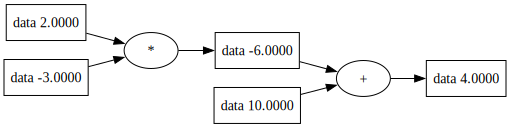

In [43]:
from graphviz import Digraph

def trace(root):
    # recursively builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ data %.4f }" % (n.data), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n_i to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# NB: The op nodes are not real objects (rectangles)
# they're simply to visualise which operation (+ or *) was used to create the actual objects (rectangles are real nodes!)
draw_dot(d)

#### 4.4. Add labels to understand what variables are where in the visualised graph

In [44]:
class Value:

    # new var _op (empty string for leafs)
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})" 

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(data=4.0)

##### 4.4.1. Update graphviz

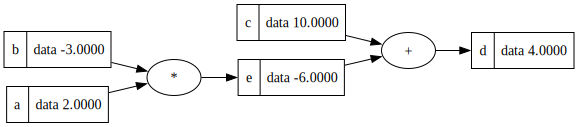

In [45]:
# Redefine graphviz to add this info:
from graphviz import Digraph

def trace(root):
    # recursively builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes: 
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
    
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
        
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        # connect n_i to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

# NB: The op nodes are not real objects (rectangles)
# they're simply to visualise which operation (+ or *) was used to create the actual objects (rectangles are real nodes!)
draw_dot(d)

##### 4.4.2. Add one more value object (go 1 layer deeper); draw 

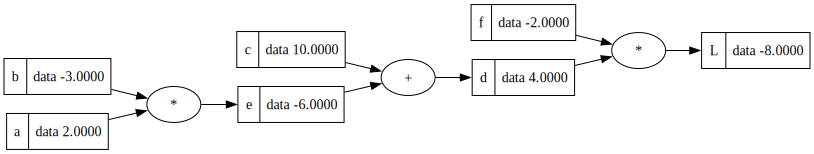

In [48]:
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # the output of our graph

draw_dot(L)

## Takeaways:
- That's the forward pass! Its output was `L=-8`
- Next, let's do backpropagation:
    - We'll work **backwards** from `L` node; and calculate the gradient at each of the intermediate values (nodes `a` to `f`)
    - Specifically, compute the derivative of each prior node (`a` to `f`) with respect to the output node `L`


### What's happening?

- In essence, `L` is the "loss function" and the prior nodes `a` to `f` represent the "weights" of a NN
    - Note: "weights" are different to the "data" held at each prior node.
- We're interested in how the weights impact the loss function
    - Hence, the **derivative of the loss function wrt the weights**

### 4.X Final `Value` object

In [ ]:
class Value:
    """docstring from GH Copilot
    A class that represents a single value and its gradient.

    This class is used to perform automatic differentiation. It keeps track of a value (`data`), its gradient (`grad`), 
    and the function (`_backward`) used to compute the gradient. The class also supports basic arithmetic operations 
    like addition (`__add__`) and multiplication (`__mul__`), as well as the hyperbolic tangent function (`tanh`).
                    
    Attributes:
        data:       The actual value.
        grad:       The gradient of the value.
        _backward:  A function that computes the gradient.
        _prev:      A set of `Value` objects that are the parents of this object in the computation graph.
        _op:        A string representing the operation that produced this `Value` object.
        label:      An optional label for the `Value` object.

    Methods:
        tanh:       Applies the hyperbolic tangent function to the value.
        backward:   Performs backpropagation to compute the gradients of all values in the computation graph.
    """

    # NB: __init__ is auto-called when you create a new instance of a class. they initialise the attributes of the class.
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    # NB: __repr__ is a Py built-in function: provides a string representation of an obj. for debugging, logging, etc
    def __repr__(self):
        return f"Value(data={self.data})" 
  
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
  
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
    
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out
  
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L